In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

import wf_psf as wf

import wf_psf.SimPSFToolkit as SimPSFToolkit
import wf_psf.utils as wf_utils
import wf_psf.tf_psf_field as tf_psf_field

In [3]:
# Plot style & colormap

import matplotlib as mpl
import matplotlib.ticker as mtick
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import ImageGrid

# Pre-defined colormap
top = mpl.cm.get_cmap('Oranges_r', 128)
bottom = mpl.cm.get_cmap('Blues', 128)
newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                       bottom(np.linspace(0, 1, 128))))
newcmp = ListedColormap(newcolors, name='OrangeBlue')


plot_style = {
    'mpl_toolkits.legacy_colorbar': False,
    'axes.formatter.use_mathtext': True,
    'text.usetex': False,
}
mpl.rcParams.update(plot_style)

plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels

# Load model

In [4]:
# Model arguments
# (replaces the cli parameters)

args_4096 = {
    'dataset_folder': './../multires_dataset/4096/',
    'train_dataset_file': 'train_Euclid_res_2000_TrainStars_id_004_wfeRes_4096.npy',
    'test_dataset_file': 'test_Euclid_res_id_004_wfeRes_4096.npy',
    'weights_paths': './../wf-outputs/chkp/4096_wfeRes/chkp_callback_poly_full_poly_wfeRes_4096_cycle2',
    'n_zernikes': 45,
    'pupil_diameter': 256,
    'output_dim': 32,
    'oversampling_rate': 3.,
    'output_q': 3.,
    'l2_param': 0.,
    'd_max': 2,
    'd_max_nonparam': 2,
    'x_lims': [0, 1e3],
    'y_lims': [0, 1e3],
    'gt_n_zernikes': 45,
    'batch_size': 16,

    'gt_pupil_diameter':4096,
}

args_256 = {
    'dataset_folder': './../multires_dataset/256/',
    'train_dataset_file': 'train_Euclid_res_2000_TrainStars_id_004_wfeRes_256.npy',
    'test_dataset_file': 'test_Euclid_res_id_004_wfeRes_256.npy',
    'weights_paths': './../wf-outputs/chkp/256_wfeRes/chkp_callback_poly_full_poly_wfeRes_256_cycle2',
    'n_zernikes': 45,
    'pupil_diameter': 256,
    'output_dim': 32,
    'oversampling_rate': 3.,
    'output_q': 3.,
    'l2_param': 0.,
    'd_max': 2,
    'd_max_nonparam': 2,
    'x_lims': [0, 1e3],
    'y_lims': [0, 1e3],
    'gt_n_zernikes': 45,
    'batch_size': 16,

    'gt_pupil_diameter':256,
}

n_bins_lda = 20

# saving_dir = './../figures/'
# saving_dir = './'

In [106]:
## Load datasets
#train_dataset_256 = np.load(args_256['dataset_folder'] + args_256['train_dataset_file'], allow_pickle=True)[()]
train_dataset_4096 = np.load(args_4096['dataset_folder'] + args_4096['train_dataset_file'], allow_pickle=True)[()]
# train_stars = train_dataset['stars']
#noisy_train_stars_256 = train_dataset_256['noisy_stars']
# train_pos = train_dataset['positions']
#train_SEDs_256 = train_dataset_256['SEDs']
# train_zernike_coef = train_dataset['zernike_coef']
train_C_poly = train_dataset_4096['C_poly']
#train_parameters = train_dataset_256['parameters']

test_dataset_4096 = np.load(args_4096['dataset_folder'] + args_4096['test_dataset_file'], allow_pickle=True)[()]
test_stars = test_dataset_4096['stars']
test_pos = test_dataset_4096['positions']
test_SEDs = test_dataset_4096['SEDs']
test_zernike_coef = test_dataset_4096['zernike_coef']

# # Convert to tensor
# tf_noisy_train_stars = tf.convert_to_tensor(train_dataset['noisy_stars'], dtype=tf.float32)
# tf_train_pos = tf.convert_to_tensor(train_dataset['positions'], dtype=tf.float32)
# tf_test_pos = tf.convert_to_tensor(test_dataset['positions'], dtype=tf.float32)

# print('Dataset parameters:')
# print(train_parameters)

In [6]:
## Prepare zernikes and obscurations for both models (256x256 WFE_resolution)
# Generate Zernike maps for both models
zernikes_256 = wf_utils.zernike_generator(n_zernikes=args_256['n_zernikes'], wfe_dim=args_256['pupil_diameter'])
# Now as cubes
np_zernike_cube_256 = np.zeros((len(zernikes_256), zernikes_256[0].shape[0], zernikes_256[0].shape[1]))
for it in range(len(zernikes_256)):
    np_zernike_cube_256[it,:,:] = zernikes_256[it]
np_zernike_cube_256[np.isnan(np_zernike_cube_256)] = 0
tf_zernike_cube_256 = tf.convert_to_tensor(np_zernike_cube_256, dtype=tf.float32)

# Get obscurations for both models
simPSF_np_256 = SimPSFToolkit(
    zernikes_256,
    max_order=args_256['n_zernikes'],
    pupil_diameter=args_256['pupil_diameter'],
    output_dim=args_256['output_dim'],
    oversampling_rate=args_256['oversampling_rate'],
    output_Q=args_256['output_q']
)
#simPSF_np.gen_random_Z_coeffs(max_order=args_256['n_zernikes'])
#z_coeffs = simPSF_np.normalize_zernikes(simPSF_np.get_z_coeffs(), simPSF_np.max_wfe_rms)
#simPSF_np.set_z_coeffs(z_coeffs)
#simPSF_np.generate_mono_PSF(lambda_obs=0.7, regen_sample=False)

# Obscurations
#obscurations = simPSF_np.generate_pupil_obscurations(N_pix=args['pupil_diameter'], N_filter=2)
obscurations_256 = np.copy(simPSF_np_256.obscurations)
tf_obscurations_256 = tf.convert_to_tensor(obscurations_256, dtype=tf.complex64)

# Outputs (needed for the MCCD model)
#outputs = tf_noisy_train_stars



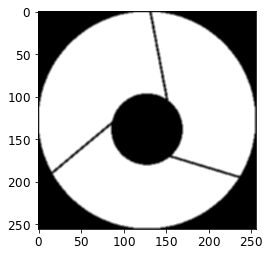

In [7]:
plt.imshow(obscurations_256, cmap='gray')

In [8]:
## Prepare models

# # Initialize the models
tf_semiparam_field_256 = tf_psf_field.TF_SemiParam_field(
    zernike_maps=tf_zernike_cube_256,
    obscurations=tf_obscurations_256,
    batch_size=args_256['batch_size'],
    output_Q=args_256['output_q'],
    d_max_nonparam=args_256['d_max_nonparam'],
    l2_param=args_256['l2_param'],
    output_dim=args_256['output_dim'],
    n_zernikes=args_256['n_zernikes'],
    d_max=args_256['d_max'],
    x_lims=args_256['x_lims'],
    y_lims=args_256['y_lims']
)

tf_semiparam_field_4096 = tf_psf_field.TF_SemiParam_field(
    zernike_maps=tf_zernike_cube_256,
    obscurations=tf_obscurations_256,
    batch_size=args_4096['batch_size'],
    output_Q=args_4096['output_q'],
    d_max_nonparam=args_4096['d_max_nonparam'],
    l2_param=args_4096['l2_param'],
    output_dim=args_4096['output_dim'],
    n_zernikes=args_4096['n_zernikes'],
    d_max=args_4096['d_max'],
    x_lims=args_4096['x_lims'],
    y_lims=args_4096['y_lims']
)

In [9]:
## Load the model's weights
tf_semiparam_field_256.load_weights(args_256['weights_paths'])
tf_semiparam_field_4096.load_weights(args_4096['weights_paths'])

# Get the data-driven features
DD_features_256 = tf_semiparam_field_256.tf_np_poly_opd.S_mat.numpy()
DD_features_4096 = tf_semiparam_field_4096.tf_np_poly_opd.S_mat.numpy()

# Prepare the Ground Truth (GT) model

In [10]:
## Prepare ground truth model
# Generate Zernike maps
zernikes_4096 = wf_utils.zernike_generator(n_zernikes=args_4096['gt_n_zernikes'], wfe_dim=args_4096['gt_pupil_diameter'])
# Now as cubes
np_zernike_cube_4096 = np.zeros((len(zernikes_4096), zernikes_4096[0].shape[0], zernikes_4096[0].shape[1]))
for it in range(len(zernikes_4096)):
    np_zernike_cube_4096[it,:,:] = zernikes_4096[it]
np_zernike_cube_4096[np.isnan(np_zernike_cube_4096)] = 0
tf_zernike_cube_4096 = tf.convert_to_tensor(np_zernike_cube_4096, dtype=tf.float32)

simPSF_np_4096 = SimPSFToolkit(
    zernikes_4096,
    max_order=args_4096['n_zernikes'],
    pupil_diameter=args_4096['gt_pupil_diameter'],
    output_dim=args_4096['output_dim'],
    oversampling_rate=args_4096['oversampling_rate'],
    output_Q=args_4096['output_q']
)

obscurations_4096 = np.copy(simPSF_np_4096.obscurations)
tf_obscurations_4096 = tf.convert_to_tensor(obscurations_4096, dtype=tf.complex64)


In [11]:

# Initialize the models
GT_tf_semiparam_field_256 = tf_psf_field.TF_SemiParam_field(
    zernike_maps=tf_zernike_cube_256,
    obscurations=tf_obscurations_256,
    batch_size=args_256['batch_size'],
    output_Q=args_256['output_q'],
    d_max_nonparam=args_256['d_max_nonparam'],
    output_dim=args_256['output_dim'],
    n_zernikes=args_256['gt_n_zernikes'],
    d_max=args_256['d_max'],
    x_lims=args_256['x_lims'],
    y_lims=args_256['y_lims']
)

GT_tf_semiparam_field_4096 = tf_psf_field.TF_SemiParam_field(
    zernike_maps=tf_zernike_cube_4096,
    obscurations=tf_obscurations_4096,
    batch_size=args_4096['batch_size'],
    output_Q=args_4096['output_q'],
    d_max_nonparam=args_4096['d_max_nonparam'],
    output_dim=args_4096['output_dim'],
    n_zernikes=args_4096['gt_n_zernikes'],
    d_max=args_4096['d_max'],
    x_lims=args_4096['x_lims'],
    y_lims=args_4096['y_lims']
)

# For the Ground truth model
GT_tf_semiparam_field_256.tf_poly_Z_field.assign_coeff_matrix(train_C_poly)
_ = GT_tf_semiparam_field_256.tf_np_poly_opd.alpha_mat.assign(
    np.zeros_like(GT_tf_semiparam_field_256.tf_np_poly_opd.alpha_mat)
)

GT_tf_semiparam_field_4096.tf_poly_Z_field.assign_coeff_matrix(train_C_poly)
_ = GT_tf_semiparam_field_4096.tf_np_poly_opd.alpha_mat.assign(
    np.zeros_like(GT_tf_semiparam_field_4096.tf_np_poly_opd.alpha_mat)
)


# Learned data-driven features

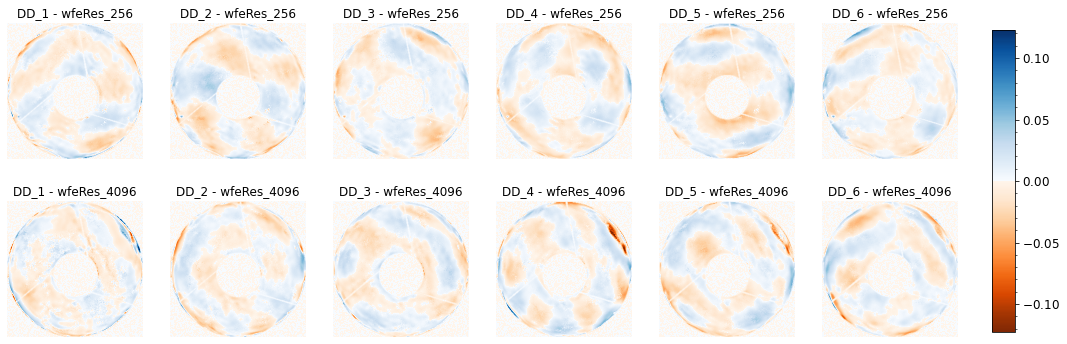

In [12]:
id_maps = [0, 1, 2, 3, 4, 5]

vmax = np.max(abs(DD_features_256[id_maps,:,:]))

fig = plt.figure(figsize=(16, 6))
for idx in id_maps:
    plt.subplot(2,6,1+idx)
    im = plt.imshow(DD_features_256[id_maps[idx],:,:], cmap=newcmp, vmax=vmax, vmin=-vmax)
    plt.axis('off')
    plt.title('DD_{idx} - wfeRes_256'.format(idx=idx+1))
    plt.subplot(2,6,2+id_maps[-1]+idx)
    plt.imshow(DD_features_4096[id_maps[idx],:,:], cmap=newcmp, vmax=vmax, vmin=-vmax)
    plt.axis('off')
    plt.title('DD_{idx} - wfeRes_4096'.format(idx=idx+1))

# Colorbar
fig.subplots_adjust(right=0.95)
cbar = fig.add_axes([0.98, 0.15, 0.02, 0.7])
fig.colorbar( im , cax=cbar)
cbar.minorticks_on()

plt.savefig('../wf-outputs/plots/DD_features.pdf')
plt.show()

# PSF Recovery

In [14]:
n_stars = 1

tf_SEDs = test_SEDs[0:n_stars,:,:]
tf_test_pos = tf.convert_to_tensor(test_pos[0:n_stars,:], dtype=tf.float32)
batch_size = args_256['batch_size']


# Generate SED data lists
packed_SED_data_256 = [wf.utils.generate_packed_elems(_sed, simPSF_np_256, n_bins=n_bins_lda)
                        for _sed in tf_SEDs]
tf_packed_SED_data_256 = tf.convert_to_tensor(packed_SED_data_256, dtype=tf.float32)
tf_packed_SED_data_256 = tf.transpose(tf_packed_SED_data_256, perm=[0, 2, 1])
pred_inputs_256 = [tf_test_pos , tf_packed_SED_data_256]

packed_SED_data_4096 = [wf.utils.generate_packed_elems(_sed, simPSF_np_4096, n_bins=n_bins_lda)
                        for _sed in tf_SEDs]
tf_packed_SED_data_4096 = tf.convert_to_tensor(packed_SED_data_4096, dtype=tf.float32)
tf_packed_SED_data_4096 = tf.transpose(tf_packed_SED_data_4096, perm=[0, 2, 1])
pred_inputs_4096 = [tf_test_pos , tf_packed_SED_data_4096]

# Model prediction
preds_256 = tf_semiparam_field_256.predict(x=pred_inputs_256, batch_size=batch_size)
preds_4096 = tf_semiparam_field_4096.predict(x=pred_inputs_256, batch_size=batch_size)

# GT model prediction
GT_preds_256 = GT_tf_semiparam_field_256.predict(x=pred_inputs_256, batch_size=batch_size)
#GT_preds_4096 = GT_tf_semiparam_field_4096.predict(x=pred_inputs_4096, batch_size=batch_size)

In [14]:
#GT_preds_4096 = GT_tf_semiparam_field_4096.predict(x=pred_inputs_4096, batch_size=1)

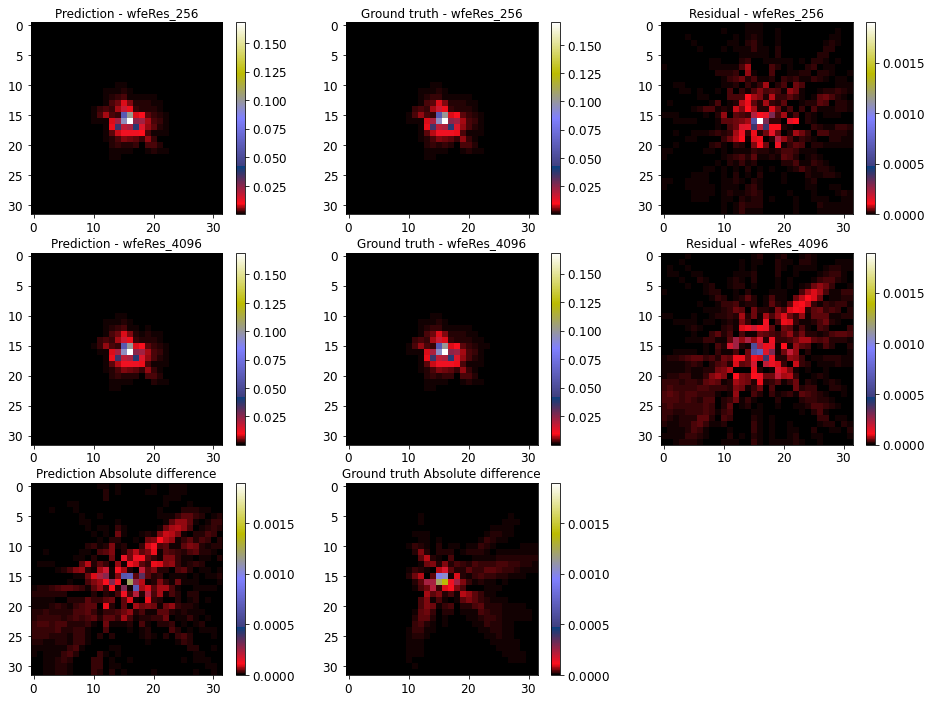

In [15]:
test_star = 0
vmax = np.max(np.abs(GT_preds_256[test_star,:,:] - preds_256[test_star,:,:]))

fig, ax = plt.subplots(3, 3, figsize=(16,12))

im = ax[0][0].imshow(preds_256[test_star,:,:], cmap='gist_stern')
ax[0][0].set_title('Prediction - wfeRes_256')
plt.colorbar(im, ax=ax[0][0])

im = ax[0][1].imshow(GT_preds_256[test_star,:,:], cmap='gist_stern')
ax[0][1].set_title('Ground truth - wfeRes_256')
plt.colorbar(im, ax=ax[0][1])

im = ax[0][2].imshow(np.abs(GT_preds_256[test_star,:,:] - preds_256[test_star,:,:]), cmap='gist_stern', vmax=vmax, vmin=0)
ax[0][2].set_title('Residual - wfeRes_256')
plt.colorbar(im, ax=ax[0][2])

im = ax[1][0].imshow(preds_4096[test_star,:,:], cmap='gist_stern')
ax[1][0].set_title('Prediction - wfeRes_4096')
plt.colorbar(im, ax=ax[1][0])

im = ax[1][1].imshow(test_stars[test_star,:,:], cmap='gist_stern')
ax[1][1].set_title('Ground truth - wfeRes_4096')
plt.colorbar(im, ax=ax[1][1])

im = ax[1][2].imshow(np.abs(test_stars[test_star,:,:] - preds_4096[test_star,:,:]), cmap='gist_stern', vmax=vmax, vmin=0)
ax[1][2].set_title('Residual - wfeRes_4096')
plt.colorbar(im, ax=ax[1][2])

im = ax[2][0].imshow(np.abs(preds_256[test_star,:,:] - preds_4096[test_star,:,:]), cmap='gist_stern', vmax=vmax, vmin=0)
ax[2][0].set_title('Prediction Absolute difference')
plt.colorbar(im, ax=ax[2][0])

im = ax[2][1].imshow(np.abs(GT_preds_256[test_star,:,:] - test_stars[test_star,:,:]), cmap='gist_stern', vmax=vmax, vmin=0)

ax[2][1].set_title('Ground truth Absolute difference')
plt.colorbar(im, ax=ax[2][1])

#im = ax[2][2].imshow(np.abs(test_stars[test_star,:,:] - preds_4096[test_star,:,:]), cmap='gist_stern')
#ax[2][2].set_title('Residual - wfeRes_4096')
#plt.colorbar(im, ax=ax[2][2])
ax[2][2].axis('off')

plt.savefig('../wf-outputs/plots/PSF_comparison.pdf')
plt.show()

## At 3x resolution

In [27]:
output_Q=1
output_dim=64


# Save original output_Q and output_dim
original_out_Q = tf_semiparam_field_256.output_Q
original_out_dim = tf_semiparam_field_256.output_dim
GT_original_out_Q = GT_tf_semiparam_field_256.output_Q
GT_original_out_dim = GT_tf_semiparam_field_256.output_dim

# Set the required output_Q and output_dim parameters in the models
tf_semiparam_field_256.set_output_Q(output_Q=output_Q, output_dim=output_dim)
GT_tf_semiparam_field_256.set_output_Q(output_Q=output_Q, output_dim=output_dim)

tf_semiparam_field_4096.set_output_Q(output_Q=output_Q, output_dim=output_dim)
GT_tf_semiparam_field_4096.set_output_Q(output_Q=output_Q, output_dim=output_dim)

# Need to compile the models again
tf_semiparam_field_256_3x = wf.tf_psf_field.build_PSF_model(tf_semiparam_field_256)
GT_tf_semiparam_field_256_3x = wf.tf_psf_field.build_PSF_model(GT_tf_semiparam_field_256)

tf_semiparam_field_4096_3x = wf.tf_psf_field.build_PSF_model(tf_semiparam_field_4096)
GT_tf_semiparam_field_4096_3x = wf.tf_psf_field.build_PSF_model(GT_tf_semiparam_field_4096)


# # Generate SED data list
# packed_SED_data = [wf.utils.generate_packed_elems(_sed, simPSF_np_256, n_bins=n_bins_lda)
#                         for _sed in tf_SEDs]

# # Prepare inputs
# tf_packed_SED_data = tf.convert_to_tensor(packed_SED_data, dtype=tf.float32)
# tf_packed_SED_data = tf.transpose(tf_packed_SED_data, perm=[0, 2, 1])
# pred_inputs = [tf_test_pos , tf_packed_SED_data]

# PSF model
predictions = tf_semiparam_field_256_3x.predict(x=pred_inputs_256, batch_size=batch_size)

# Ground Truth model
GT_predictions = GT_tf_semiparam_field_256_3x.predict(x=pred_inputs_256, batch_size=batch_size)


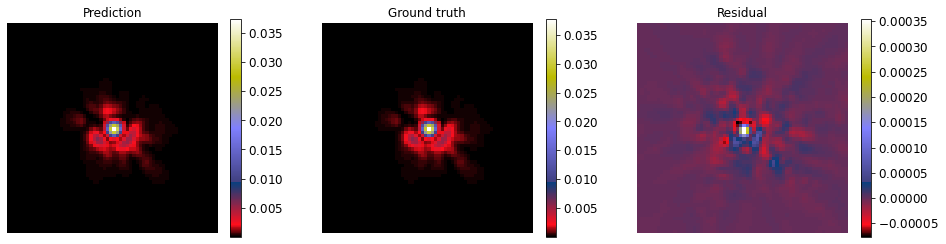

In [28]:
fig, ax = plt.subplots(1, 3, figsize=(16,4))

im = ax[0].imshow(predictions[test_star,:,:], cmap='gist_stern')
ax[0].set_title('Prediction')
plt.colorbar(im, ax=ax[0])


im = ax[1].imshow(GT_predictions[test_star,:,:], cmap='gist_stern')
ax[1].set_title('Ground truth')
plt.colorbar(im, ax=ax[1])

im = ax[2].imshow(GT_predictions[test_star,:,:] - predictions[it,:,:], cmap='gist_stern')
ax[2].set_title('Residual')
plt.colorbar(im, ax=ax[2])

for j in range(3):
    ax[j].set_xticks([])
    ax[j].set_yticks([])
    ax[j].spines['top'].set_visible(False)
    ax[j].spines['right'].set_visible(False)
    ax[j].spines['bottom'].set_visible(False)
    ax[j].spines['left'].set_visible(False)

plt.show()


## Monochromatic at 750nm, 3x resolution

In [30]:
# Uncomment block to return to Euclid resolution
# Re-et the original output_Q and output_dim parameters in the models
# tf_semiparam_field.set_output_Q(output_Q=original_out_Q, output_dim=original_out_dim)
# GT_tf_semiparam_field.set_output_Q(output_Q=GT_original_out_Q, output_dim=GT_original_out_dim)

# Need to compile the models again
# tf_semiparam_field = wf.tf_psf_field.build_PSF_model(tf_semiparam_field)
# GT_tf_semiparam_field = wf.tf_psf_field.build_PSF_model(GT_tf_semiparam_field)


lambda_obs = 0.750

phase_N = simPSF_np_256.feasible_N(lambda_obs)
batch_pos = tf_test_pos

# Estimate the monochromatic PSFs
GT_mono_psf = GT_tf_semiparam_field_256.predict_mono_psfs(
    input_positions=batch_pos,
    lambda_obs=lambda_obs,
    phase_N=phase_N)

model_mono_psf = tf_semiparam_field_256.predict_mono_psfs(
    input_positions=batch_pos,
    lambda_obs=lambda_obs,
    phase_N=phase_N)


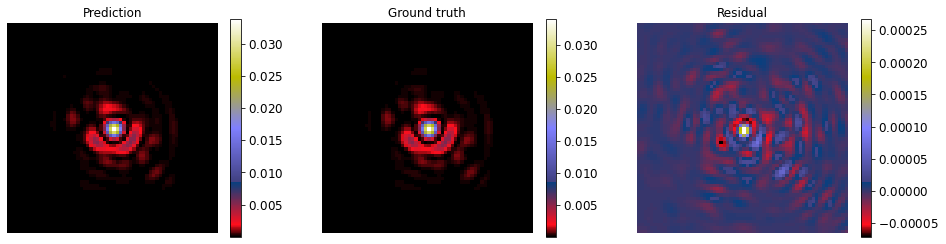

In [31]:
fig, ax = plt.subplots(1, 3, figsize=(16,4))

im = ax[0].imshow(model_mono_psf[test_star,:,:], cmap='gist_stern')
ax[0].set_title('Prediction')
plt.colorbar(im, ax=ax[0])

im = ax[1].imshow(GT_mono_psf[test_star,:,:], cmap='gist_stern')
ax[1].set_title('Ground truth')
plt.colorbar(im, ax=ax[1])

im = ax[2].imshow(GT_mono_psf[test_star,:,:] - model_mono_psf[test_star,:,:], cmap='gist_stern')
ax[2].set_title('Residual')
plt.colorbar(im, ax=ax[2])

for j in range(3):
    ax[j].set_xticks([])
    ax[j].set_yticks([])
    ax[j].spines['top'].set_visible(False)
    ax[j].spines['right'].set_visible(False)
    ax[j].spines['bottom'].set_visible(False)
    ax[j].spines['left'].set_visible(False)

plt.show()


# WFE reconstruction

In [32]:
batch_pos = tf_test_pos

# We calculate a batch of OPDs
opd_batch_4096 = tf_semiparam_field_4096.predict_opd(batch_pos)
opd_batch_256 = tf_semiparam_field_256.predict_opd(batch_pos)

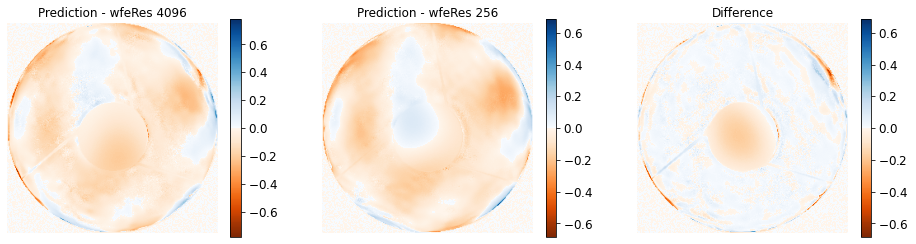

In [33]:
fig, ax = plt.subplots(1, 3, figsize=(16,4))

vmax = np.max(np.abs(opd_batch_4096[test_star,:,:]))
im = ax[0].imshow(opd_batch_4096[test_star,:,:], cmap=newcmp, vmax=vmax, vmin=-vmax)
ax[0].set_title('Prediction - wfeRes 4096')
plt.colorbar(im, ax=ax[0])


vmax = np.max(np.abs(opd_batch_256[test_star,:,:]))
im = ax[1].imshow(opd_batch_256[test_star,:,:], cmap=newcmp, vmax=vmax, vmin=-vmax)
ax[1].set_title('Prediction - wfeRes 256')
plt.colorbar(im, ax=ax[1])

#vmax = np.max(np.abs(opd_batch_4096[it,:,:] - opd_batch_256[it,:,:]))
im = ax[2].imshow(opd_batch_4096[test_star,:,:] - opd_batch_256[test_star,:,:], cmap=newcmp, vmax=vmax, vmin=-vmax)
ax[2].set_title('Difference')
plt.colorbar(im, ax=ax[2])

for j in range(3):
    ax[j].set_xticks([])
    ax[j].set_yticks([])
    ax[j].spines['top'].set_visible(False)
    ax[j].spines['right'].set_visible(False)
    ax[j].spines['bottom'].set_visible(False)
    ax[j].spines['left'].set_visible(False)

plt.savefig('../wf-outputs/plots/WFE_comparison.pdf')
plt.show()

## Energy distribution over zernikes

In [48]:
def PI_zernikes(tf_z1,tf_z2,norm_factor=None):
    if norm_factor is None:
        norm_factor = 1
    return sum(sum(tf.math.multiply(tf_z1,tf_z2) )).numpy()/(norm_factor)

In [110]:
n_pix_zernike = PI_zernikes(tf_zernike_cube_256[0,:,:],tf_zernike_cube_256[0,:,:])

In [50]:
# Extract coefficients by proyecting the OPD over the Zernike space
z_coefs_256 = [PI_zernikes(opd_batch_256[test_star,:,:],tf_zernike_cube_256[k,:,:], n_pix_zernike) for k in range(args_256['n_zernikes'])]
z_coefs_4096 = [PI_zernikes(opd_batch_4096[test_star,:,:],tf_zernike_cube_256[k,:,:], n_pix_zernike) for k in range(args_256['n_zernikes'])]


In [111]:
test_star = 0

In [183]:
# Reconstruct parametric opd and extract the non-parametric one
param_opd_256 = sum([np_zernike_cube_256[k,:,:]*z_coefs_256[k] for k in range(args_256['n_zernikes'])])
non_param_opd_256 = opd_batch_256[test_star,:,:]-param_opd_256
gt_opd_256 = sum([np_zernike_cube_256[k,:,:]*test_zernike_coef[test_star,k,0] for k in range(args_256['gt_n_zernikes'])])

param_opd_4096 = sum([np_zernike_cube_256[k,:,:]*z_coefs_4096[k] for k in range(args_256['n_zernikes'])])
non_param_opd_4096 = opd_batch_4096[test_star,:,:]-param_opd_4096
gt_opd_4096 = sum([np_zernike_cube_4096[k,:,:]*test_zernike_coef[test_star,k,0] for k in range(args_256['gt_n_zernikes'])])

Energy param:  0.010293726478914682
Energy non param:  0.0003522952522229999


In [184]:
zernike_param_energy_256 = PI_zernikes(param_opd_256,param_opd_256,n_pix_zernike)
zernike_non_param_energy_256 = PI_zernikes(non_param_opd_256,non_param_opd_256,n_pix_zernike)

zernike_param_energy_4096 = PI_zernikes(param_opd_4096,param_opd_4096,n_pix_zernike)
zernike_non_param_energy_4096 = PI_zernikes(non_param_opd_4096,non_param_opd_4096,n_pix_zernike)

print('Energy param: ', zernike_param_energy_256)
print('Energy non param: ', zernike_non_param_energy_256)

Energy param:  0.010293726478914682
Energy non param:  0.0003522952522229999


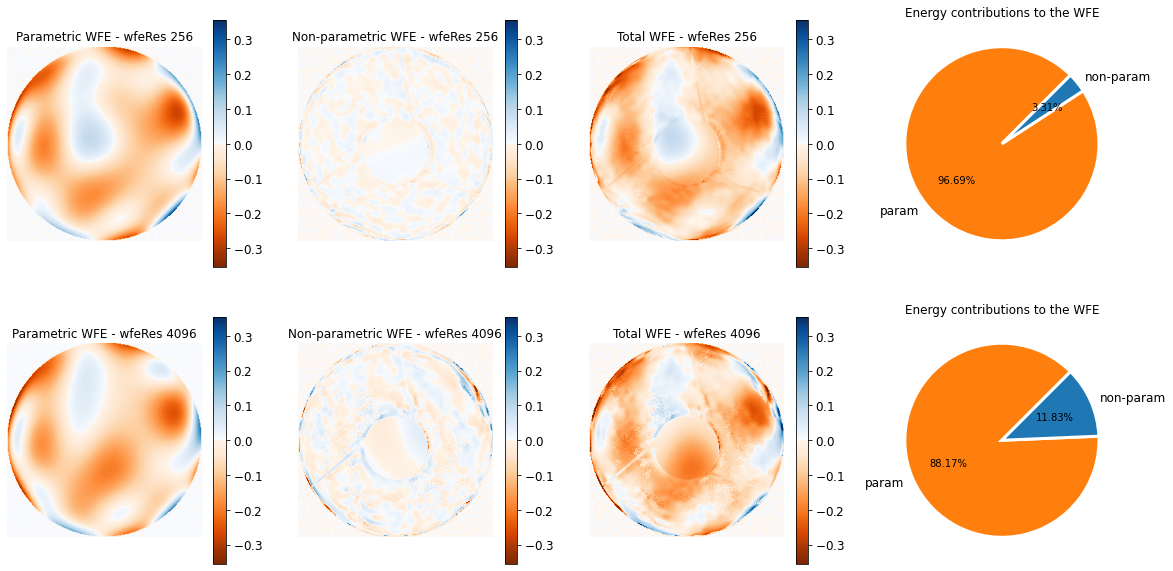

In [194]:
fig, ax = plt.subplots(2, 4, figsize=(20,10))

vmax = np.max(np.abs(param_opd_256))

im = ax[0][0].imshow(param_opd_256, cmap=newcmp, vmax=vmax, vmin=-vmax)
ax[0][0].set_title('Parametric WFE - wfeRes 256')
plt.colorbar(im, ax=ax[0][0])
im = ax[0][1].imshow(non_param_opd_256, cmap=newcmp, vmax=vmax, vmin=-vmax)
ax[0][1].set_title('Non-parametric WFE - wfeRes 256')
plt.colorbar(im, ax=ax[0][1])
im = ax[0][2].imshow(opd_batch_256[test_star,:,:], cmap=newcmp, vmax=vmax, vmin=-vmax)
ax[0][2].set_title('Total WFE - wfeRes 256')
plt.colorbar(im, ax=ax[0][2])
# im = ax[0][3].imshow(gt_opd_256, cmap=newcmp, vmax=vmax, vmin=-vmax)
# ax[0][3].set_title('Ground truth - wfeRes 256')
# plt.colorbar(im, ax=ax[0][3])
im = ax[0][3].pie([zernike_param_energy_256, zernike_non_param_energy_256], colors=['tab:orange', 'tab:blue'],labels=['param','non-param'], autopct='%1.2f%%',
        wedgeprops = { 'linewidth' : 3, 'edgecolor' : 'white' }, startangle = 45)
ax[0][3].set_title('Energy contributions to the WFE')

im = ax[1][0].imshow(param_opd_4096, cmap=newcmp, vmax=vmax, vmin=-vmax)
ax[1][0].set_title('Parametric WFE - wfeRes 4096')
plt.colorbar(im, ax=ax[1][0])
im = ax[1][1].imshow(non_param_opd_4096, cmap=newcmp, vmax=vmax, vmin=-vmax)
ax[1][1].set_title('Non-parametric WFE - wfeRes 4096')
plt.colorbar(im, ax=ax[1][1])
im = ax[1][2].imshow(opd_batch_4096[test_star,:,:], cmap=newcmp, vmax=vmax, vmin=-vmax)
ax[1][2].set_title('Total WFE - wfeRes 4096')
plt.colorbar(im, ax=ax[1][2])
# im = ax[1][3].imshow(gt_opd_4096, cmap=newcmp, vmax=vmax, vmin=-vmax)
# ax[1][3].set_title('Ground truth - wfeRes 4096')
# plt.colorbar(im, ax=ax[1][3])
im = ax[1][3].pie([zernike_param_energy_4096, zernike_non_param_energy_4096], colors=['tab:orange', 'tab:blue'],labels=['param','non-param'], autopct='%1.2f%%',
        wedgeprops = { 'linewidth' : 3, 'edgecolor' : 'white' }, startangle = 45)
ax[1][3].set_title('Energy contributions to the WFE')

for axis in ax.ravel():
    axis.set_xticks([])
    axis.set_yticks([])
    axis.spines['top'].set_visible(False)
    axis.spines['right'].set_visible(False)
    axis.spines['bottom'].set_visible(False)
    axis.spines['left'].set_visible(False)

plt.savefig('../wf-outputs/plots/WFE_energy_compare.pdf')

plt.show()